# Project Regression: Capital Bike Share 

# 1. project goal

### Build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time- and weather-related features.

This project follows a Machine Learning process similar to the one you learned last week.

#### Key steps:

* exploratory data analysis
* train/test split
* feature engineering
* train a model
* cross-validation
* optimize the model iteratively, select features, try different regressors (e.g. Linear Regression, Random Forest Regressor, SVR)
* calculate a test score when you are done
* submit to Kaggle

#### Data Fields

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

Import libraries

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV

# 2. import data

Import datasets

In [2]:
df = pd.read_csv('/Users/braulio/Documents/data/train.csv')

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### Registered vs Casual users: a final review

On a previous data exploratory analysis, both users have shown strong correlation with each other and 'count', therefore not showing much difference in behaviour. In fact, as we can see on samples on the table: Registered + Casual = count, thus we can ignore those variables.

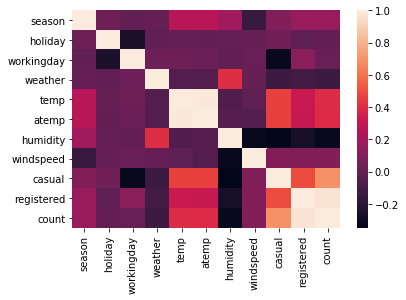

In [4]:
# Pre-eliminatory correlation heatmap:

sns.heatmap(df.corr())

#### Therefore, we define the variables of interest as:

In [5]:
y = df['count']
X = df.drop(['count', 'casual', 'registered'], axis=1)

# 3. train/test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 9), (2722, 9), (8164,), (2722,))

# 4. exploratory data analysis

In [7]:
train_data = X_train.join(y_train)

In [8]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
9792,2012-10-12 09:00:00,4,0,1,1,20.50,24.240,39,19.9995,400
3815,2011-09-09 23:00:00,3,0,1,1,25.42,27.275,94,6.0032,148
2420,2011-06-08 18:00:00,2,0,1,1,36.90,40.910,37,15.0013,459
4176,2011-10-06 01:00:00,4,0,1,1,19.68,23.485,63,12.9980,22
4283,2011-10-10 12:00:00,4,1,0,2,28.70,32.575,48,6.0032,365


In [9]:
train_data.shape

(8164, 10)

In [10]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,8164.000000,8164.00000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.517883,0.02854,0.679691,1.415483,20.275012,23.699313,61.793239,12.756427,191.341622
std,1.116315,0.16652,0.466624,0.630077,7.795902,8.478338,19.303774,8.162060,179.640277
min,1.000000,0.00000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.00000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,43.000000
50%,3.000000,0.00000,1.000000,1.000000,20.500000,24.240000,61.000000,12.998000,145.000000
75%,4.000000,0.00000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.00000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,977.000000


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8164 entries, 9792 to 1289
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   count       8164 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 1021.6+ KB


### no missing values!

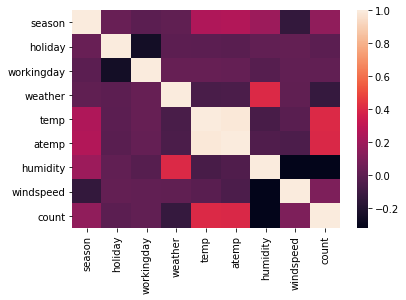

In [12]:
# Correlation heatmap:

sns.heatmap(train_data.corr())

#### Which factors seem to have the strongest correlation with Count?:
* Temp and atemp have strong positive correlation with count
* Season also shows positive correlation with count
* Weather and humidity have small negative correlation with count

other takes: 
* Weather and humidty are strongly correlated
* Windspeed and humidity are negatively correlated
* Season has positive correlation with temp


### Create time-related features
Create new df with segragated timestamps

* 1. Set index as column

* 2. Separate out hour and day in new columns

In [13]:
# separate date/time features from datetime

# convert datetime column into datetime type:
train_data['hour'] = pd.to_datetime(train_data['datetime']).dt.hour

train_data['day of the week'] = pd.to_datetime(train_data['datetime']).dt.day_name()

train_data['day'] = pd.to_datetime(train_data['datetime']).dt.day

train_data['month'] = pd.to_datetime(train_data['datetime']).dt.month

train_data['year'] = pd.to_datetime(train_data['datetime']).dt.year

# set datetime as index again
#df.set_index('datetime', inplace = True)

In [14]:
train_data.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day of the week,day,month,year
9792,2012-10-12 09:00:00,4,0,1,1,20.50,24.240,39,19.9995,400,9,Friday,12,10,2012
3815,2011-09-09 23:00:00,3,0,1,1,25.42,27.275,94,6.0032,148,23,Friday,9,9,2011


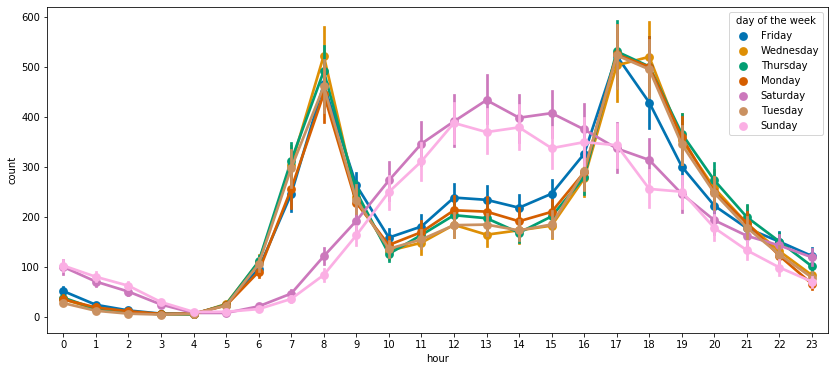

In [15]:
plt.figure(figsize=(14,6))

sns.pointplot(x = "hour", y = "count", data = train_data, hue = "day of the week", palette ='colorblind', legend='full')

As this graph points out, the weekend -- Saturday and Sunday -- has clearly a different trend throughout the day when compared to weekdays. In fact, at the time we want to predict, Saturday at 14h, there is a peak in checked-out bikes. 12h to 15h seems to be the peak hours of bike rentals during the weekends. 

.
.
.

also shown through:

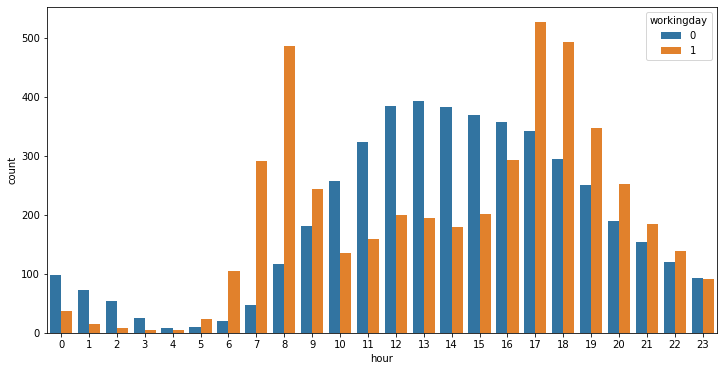

In [16]:
hours = train_data.groupby(['hour', 'workingday']).mean()
hours.reset_index(inplace = True)

plt.figure(figsize=(12,6))
sns.barplot(x = 'hour', y = 'count', data = hours, hue = 'workingday')

Trend over time

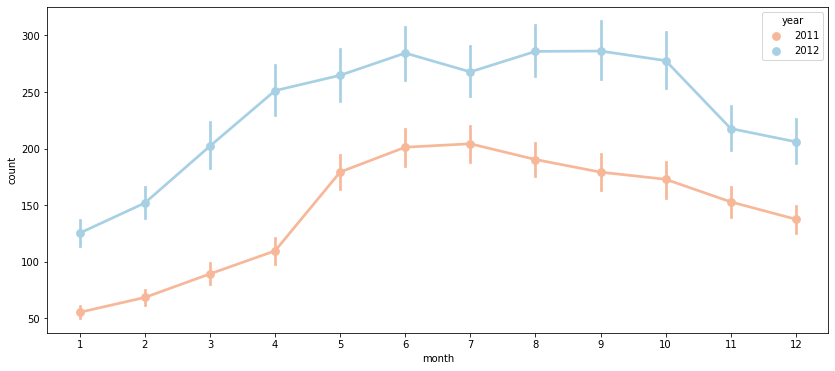

In [17]:
plt.figure(figsize=(14,6))

sns.pointplot(x = "month", y = "count", data = train_data, hue = "year", palette = "RdBu", legend='full')

Monthly patterns seeem similar, but there is an increase in rentals from 2011 to 2012. Perhaps, a constant increase in rental counts over the years can be predicted.

In [18]:
#Correlations with count at hour 14:00

train_data[train_data['hour'] == 14].drop(columns=['year','month','day']).corr()[['count']]

,count
season,0.284824
holiday,0.061678
workingday,-0.636051
weather,-0.216729
temp,0.376034
atemp,0.384456
humidity,-0.164932
windspeed,-0.056558
count,1.000000
hour,NaN


#### At 14:00, the strongest correlations with bike checkouts:

* Workingday: -63%
* atemp and temp: 38% and 37%
* Season: 28%
* Weather: -21%

In [19]:
#Correlations with count on the weekends

train_data[train_data['workingday'] == 0].drop(columns=['year','month','day']).corr()[['count']]

,count
season,0.171677
holiday,-0.014433
workingday,NaN
weather,-0.142860
temp,0.506384
atemp,0.502077
humidity,-0.427921
windspeed,0.118827
count,1.000000
hour,0.391497


#### On the weekends, the strongest correlations with bike checkouts:

* atemp and temp: 50%
* humidity: -42%
* Hour: 39%
* Weather: -14%

New dateframe to test factors that influence rentals only on weekends and at 14h00: df0

In [20]:
df0 = train_data[train_data['workingday'] == 0] #only non workingdays
df0 = df0[df0['hour'] == 14] #only at 14h00

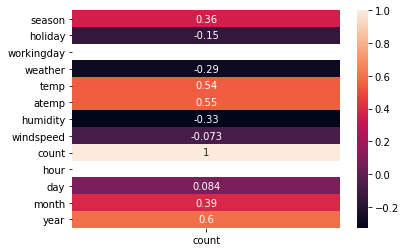

In [21]:
sns.heatmap(df0.corr()[['count']], annot=True)

#### Which factors contribute most to the number of bicycles being checkout out over the course of a given day?

* temp and atemp
* month/ season
* year
* weather and humidty

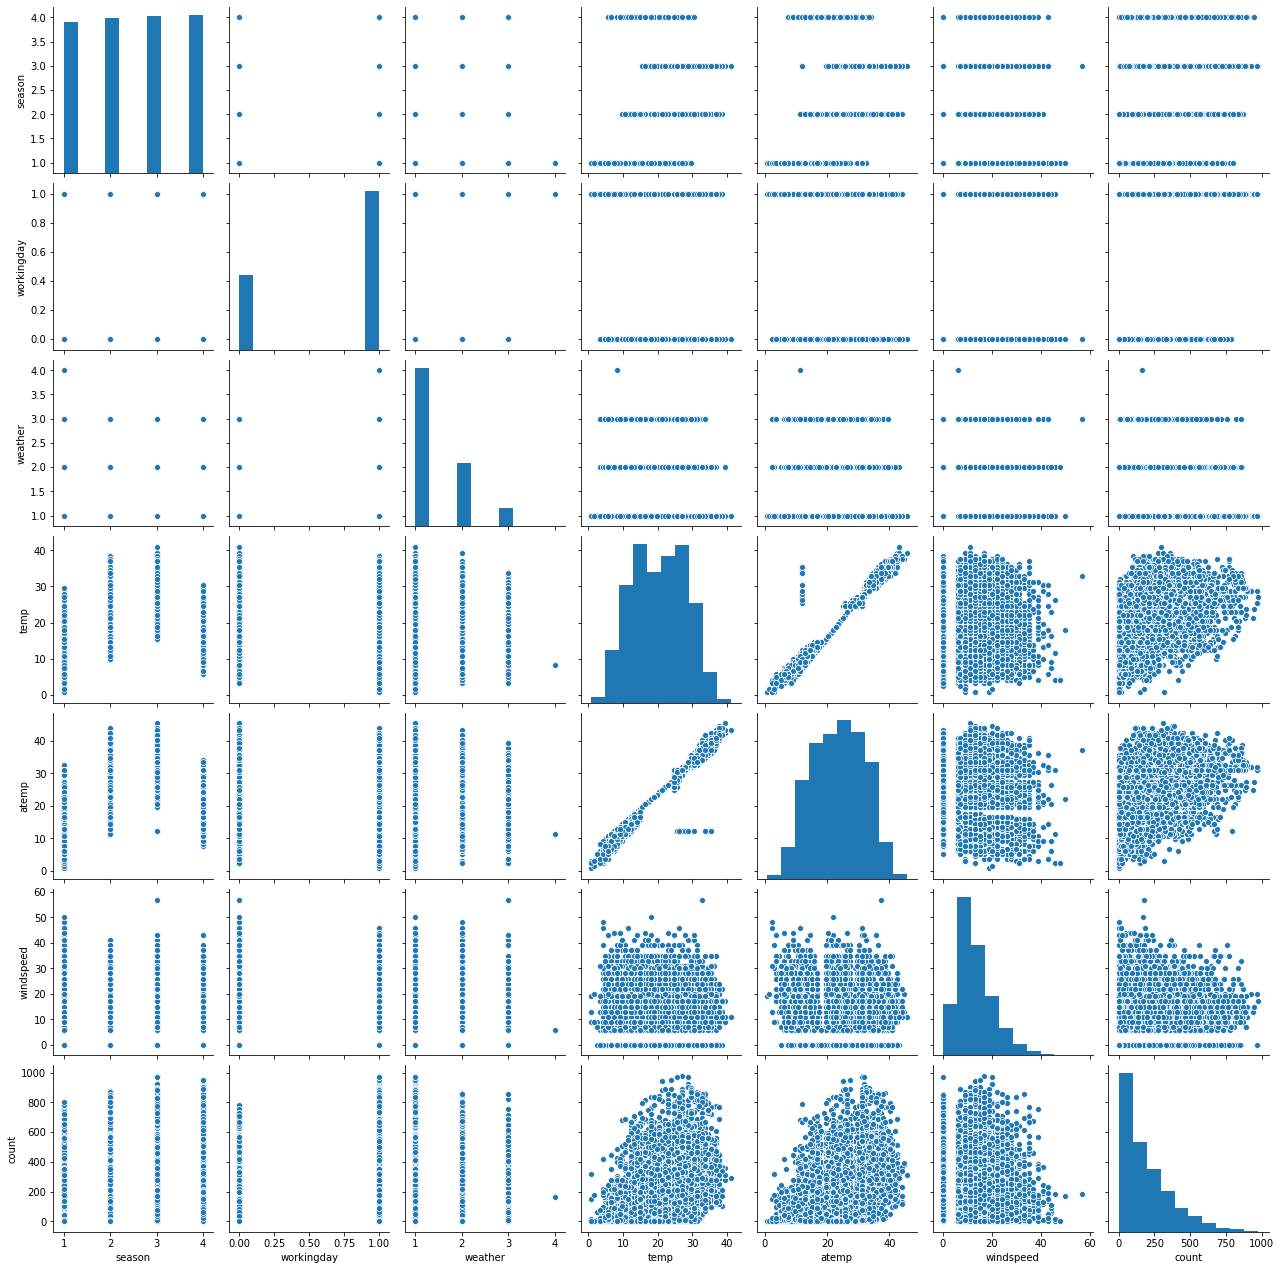

In [22]:
# Plot the relationships
sns.pairplot(train_data.drop(columns=['day', 'holiday', 'year', 'month', 'hour', 'humidity']))

The only apparent linear relationship on the graphs, relating with Count, is temp and atemp


### Analyze weather and season

In [23]:
train_data.groupby('weather').count()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,count,hour,day of the week,day,month,year
weather,,,,,,,,,,,,,,
1,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400
2,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137
3,626,626,626,626,626,626,626,626,626,626,626,626,626,626
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1


#### Only once Weather 4 is shown in the dataset, thus an analysis on its pattern is not possible

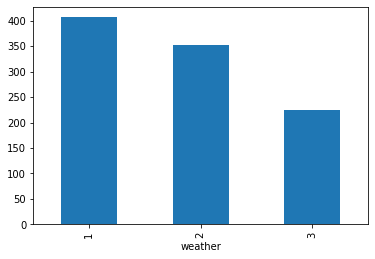

In [24]:
df0.groupby('weather').mean()['count'].plot.bar()

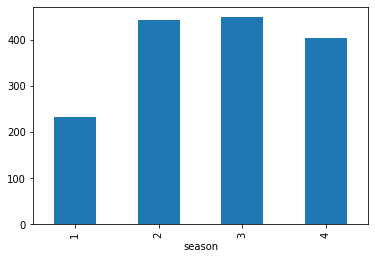

In [25]:
df0.groupby('season').mean()['count'].plot.bar()

In [26]:
train_data.corr()[['season']]

,season
season,1.000000
holiday,0.033171
workingday,-0.009815
weather,0.003717
temp,0.251126
atemp,0.256988
humidity,0.190507
windspeed,-0.144409
count,0.157027
hour,-0.015717


#### Season is highly correlated with month, almost 100%, therefore we can choose only one of them as a feature.

same for holidays and non workindays, atemp and temp, weather and humidty, etc.

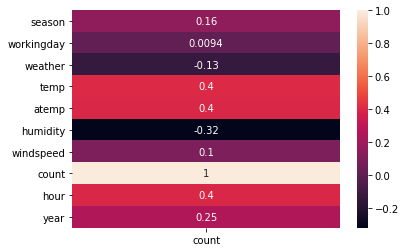

In [27]:
sns.heatmap(train_data.drop(columns=['month', 'holiday', 'day']).corr()[['count']], annot=True)

## Final considerations

### Important features that impact the number of bicycles being checkout:
* temp and atemp
* hour
* humidity
* weather
* season
* workinday x hour

most specifically on Saturdays at 14h:
* temp and atemp
* Season
* Weather and Humidty

# 5. feature engineering

In [28]:
X_train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
9792,2012-10-12 09:00:00,4,0,1,1,20.50,24.240,39,19.9995
3815,2011-09-09 23:00:00,3,0,1,1,25.42,27.275,94,6.0032
2420,2011-06-08 18:00:00,2,0,1,1,36.90,40.910,37,15.0013


Drop unwanted features:

In [29]:
X_train = X_train.drop(columns= ['holiday','temp'])

X_train.head(1)

,datetime,season,workingday,weather,atemp,humidity,windspeed
9792,2012-10-12 09:00:00,4,1,1,24.24,39,19.9995


Time features extracted from df based on EDA: hour, year, day of the week

In [70]:
# Extract the hour of the day from the datetime
def create_timefs(df):
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['year'] = pd.to_datetime(df['datetime']).dt.year
    df['day'] = pd.to_datetime(df['datetime']).dt.dayofweek
    return df

In [141]:
create_timefs(X_train)

,datetime,season,workingday,weather,atemp,humidity,windspeed,hour,year,day
9792,2012-10-12 09:00:00,4,1,1,24.240,39,19.9995,9,2012,4
3815,2011-09-09 23:00:00,3,1,1,27.275,94,6.0032,23,2011,4
2420,2011-06-08 18:00:00,2,1,1,40.910,37,15.0013,18,2011,2
4176,2011-10-06 01:00:00,4,1,1,23.485,63,12.9980,1,2011,3
4283,2011-10-10 12:00:00,4,0,2,32.575,48,6.0032,12,2011,0
...,...,...,...,...,...,...,...,...,...,...
9372,2012-09-13 21:00:00,3,1,1,30.305,65,7.0015,21,2012,3
7291,2012-05-03 04:00:00,2,1,2,22.725,88,16.9979,4,2012,3
1344,2011-04-01 21:00:00,2,1,1,16.665,53,8.9981,21,2011,4
7293,2012-05-03 06:00:00,2,1,2,22.725,88,11.0014,6,2012,3


In [ ]:
'''dummy_features = ['day','season','hour','weather']
interaction_features = ['workingday', 'hour','atemp','humidity']
passthrough_features = ['atemp', 'windspeed', 'humidity', 'year']


column_transformer = ColumnTransformer(transformers=[
                        ('dummy', OneHotEncoder(), dummy_features),
                        ('interaction_polynomial', 
                         PolynomialFeatures(interaction_only=True), interaction_features),
                        ('pass', 'passthrough', passthrough_features)
])'''

In [156]:
dummy_features = ['workingday','season','hour']
interaction_features = ['workingday', 'hour','humidity','season','atemp', 'weather']
passthrough_features = ['atemp', 'windspeed', 'humidity', 'year', 'hour']

In [157]:
column_transformer = ColumnTransformer(transformers=[
                        ('dummy', OneHotEncoder(), dummy_features),
                        ('interaction_polynomial', 
                         PolynomialFeatures(interaction_only=True), interaction_features),
                        ('pass', 'passthrough', passthrough_features)
])

In [158]:
transformer_pipeline = Pipeline(steps=[
                        ('create_timefs', FunctionTransformer(create_timefs)),
                        ('column_transformer', column_transformer)
])

In [159]:
transformer_pipeline.fit_transform(X_train)

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 3.900e+01, 2.012e+03,
        9.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 9.400e+01, 2.011e+03,
        2.300e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 3.700e+01, 2.011e+03,
        1.800e+01],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 5.300e+01, 2.011e+03,
        2.100e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 8.800e+01, 2.012e+03,
        6.000e+00],
       [0.000e+00, 1.000e+00, 1.000e+00, ..., 3.900e+01, 2.011e+03,
        1.400e+01]])

# 6. fit a model

#### baseline model

In [160]:
X_train_transformed = transformer_pipeline.fit_transform(X_train)

In [161]:
base_m = DummyRegressor(strategy='mean')
base_m.fit(X_train_transformed, y_train)

DummyRegressor()

In [162]:
base_m.score(X_test, y_test)

-2.51061226692606e-05

#### LINEAR REGRESSION

In [163]:
# Option 1 - standalone
#m = LinearRegression()
#X_train_transformed = transformer_pipeline.fit_transform(X_train)
#m.fit(X_train_transformed, y_train)

In [164]:
# Option 2 - pipeline
linear_regression = Pipeline(steps=[
    ('transformer', transformer_pipeline),('regression', LinearRegression())
])

In [165]:
linear_regression.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('create_timefs',
                                  FunctionTransformer(func=<function create_timefs at 0x7fac161d5d40>)),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('dummy',
                                                                   OneHotEncoder(),
                                                                   ['workingday',
                                                                    'season',
                                                                    'hour']),
                                                                  ('interaction_polynomial',
                                                                   PolynomialFeatures(interaction_only=True),
                                                                   ['workingday',
                                                                    'hour

In [166]:
linear_regression.score(X_train, y_train)

0.7226998013136678

# 7. cross validation

In [167]:
m = LinearRegression()
X_train_transformed = transformer_pipeline.fit_transform(X_train)
m.fit(X_train_transformed, y_train)

LinearRegression()

In [168]:
m.score(X_train_transformed, y_train)

0.7226998013136678

In [169]:
cross_val_score(m, X_train_transformed, y_train)

array([0.72212915, 0.7382055 , 0.70585185, 0.71217493, 0.71711795])

# 8. optimize the model

select features, try different regressors (e.g. Linear Regression, Random Forest Regressor, SVR)

# test|

In [174]:
X_test_transformed = transformer_pipeline.fit_transform(X_test)

In [175]:
X_test_transformed.shape

(2722, 57)

In [176]:
m.fit(X_test_transformed, y_test)

m.score(X_test_transformed, y_test)

0.7230827263353138